In [2]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt
import graphviz

## Lecture 14 - Correlated Features 

## Multilevel Adventures

**Clusters** : Kinds of groups in the data (districts)

**Features** : Aspects of the model (parameters) that vary by cluster (rural,urban)

There is useful information to transfer across features.

e.g. If you only knew the urban contraceptive use in a district, then you could use the correlation to make a better guess at the rural use in that district. But you have to know the correlation exists. 

We will be doing partial pooling  across features. 


## Adding Correlated Features

One prior distribution for each cluster

One feature: One-dimensional distribution (Varying intercepts)

Two features: Two-D distribution (Multivariate)

N features: N-dimensional distribution

Hard part: Learning associations 

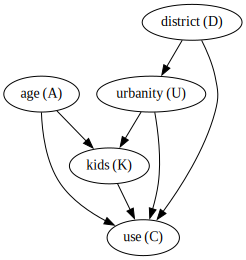

In [77]:
b = graphviz.Digraph('b')

b.edge('age (A)','use (C)')
b.edge('kids (K)','use (C)')
b.edge('urbanity (U)','use (C)')
b.edge('district (D)','use (C)')

b.edge('age (A)','kids (K)')
b.edge('urbanity (U)','kids (K)')
b.edge('district (D)','urbanity (U)')
b_graph = b
b_graph

In [16]:
bang = pd.read_csv('Data/bangladesh.csv',sep=';')
bang.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


In [17]:
#From previous lecture 
with pm.Model() as bangunc_m: #Non centered varying intercepts model
    
    C = pm.MutableData('C',bang['use.contraception'].values)
    D = pm.MutableData('D',bang['district'].values -1)
    U = pm.MutableData('U',bang['urban'])
    #Hyper-priors
    sigma = pm.Exponential('sigma',1)
    tau   = pm.Exponential('tau',1)
    abar  = pm.Normal('abar',0,1)
    bbar  = pm.Normal('bbar',0,1)
    #Z-scored effects
    za    = pm.Normal('za',0,1,shape=61)
    zb    = pm.Normal('zb',0,1,shape=61)
    
    a     = abar +za*sigma 
    b     = bbar +zb*tau
    
    logit_p = a[D] +b[D]*U
    Cobs = pm.Bernoulli('Cobs',logit_p = logit_p,observed = C)
    
    bangunc_trace = pm.sample()

G:\Statistical_Rethinking\rethinking\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [19]:
with pm.Model() as bangcentred: #Centred version of above. 
    
    C = pm.MutableData('C',bang['use.contraception'].values)
    D = pm.MutableData('D',bang['district'].values -1)
    U = pm.MutableData('U',bang['urban'])
    #Hyper-priors
    sigma = pm.Exponential('sigma',1)
    tau   = pm.Exponential('tau',1)
    abar  = pm.Normal('abar',0,1)
    bbar  = pm.Normal('bbar',0,1)
    #Want to collapse a and b
    a    = pm.Normal('a',abar,sigma,shape=61) #Each alpha gives partial pooling across sample
    b    = pm.Normal('b',bbar,tau,shape=61) # Same as alphas

    logit_p = a[D] +b[D]*U
    Cobs = pm.Bernoulli('Cobs',logit_p = logit_p,observed = C)
    
    bangcentred_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, abar, bbar, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Multivariate normal:

Need three things to describe shape

[aj,bj] ~ MVNormal([abar,bbar],R,[sigma,tau])

[aj,bj] Features for district j drawn from

[abar,bbar] = feature means

R = correlation matrix, same dimension as number of features

[sigma,tau] = vector of standard deviations. 

Ci ~ Bernoullii(pi)

logit(pi) = aD[i] + bD[i]Ui

[aj,bj] ~ MVNormal([abar,bbar],R,[sigma,tau])

abar,bbar ~ Normal(0,1)

sigma,tau ~ Exponential(1)

R ~ LKJCorr(4)

In [24]:
with pm.Model() as mCDUcov:
    C = pm.MutableData('C',bang['use.contraception'].values)
    D = pm.MutableData('D',bang['district'].values -1)
    U = pm.MutableData('U',bang['urban'])
    #priors - centered correlated varying effects
    sd_dist = pm.Exponential.dist(1,size=2)
    chol,corr, sigmas   = pm.LKJCholeskyCov('Rho', eta = 4, n=2,sd_dist=sd_dist)
    abar  = pm.Normal('abar',0,1,shape=2)
    v    = pm.MvNormal('v',mu=abar,chol=chol,shape=(61,2))
    
    # Define effects using other parameters
    a = pm.Deterministic('a', v[:,0])
    b = pm.Deterministic('b',v[:,1])


    logit_p = a[D] +b[D]*U
    Cobs = pm.Bernoulli('Cobs',logit_p = logit_p,observed = C)
    
    mCDUcov_trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, abar, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


In [43]:
mCDUcov_sum =  az.summary(mCDUcov_trace,var_names=['~v'])
mCDUcov_sum

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
abar[0],-0.702,0.098,-0.881,-0.511,0.002,0.001,2442.0,2909.0,1.00
abar[1],0.681,0.165,0.363,0.983,0.004,0.003,1960.0,2693.0,1.00
Rho[0],0.558,0.093,0.383,0.733,0.003,0.002,1019.0,1767.0,1.01
Rho[1],-0.432,0.197,-0.805,-0.070,0.008,0.005,650.0,1372.0,1.01
Rho[2],0.611,0.160,0.331,0.925,0.007,0.005,483.0,511.0,1.01
...,...,...,...,...,...,...,...,...,...
b[56],0.805,0.634,-0.331,2.052,0.010,0.008,3823.0,2760.0,1.00
b[57],-0.178,0.554,-1.182,0.844,0.013,0.009,1888.0,2286.0,1.00
b[58],1.051,0.790,-0.426,2.559,0.014,0.012,3163.0,2367.0,1.00
b[59],0.699,0.573,-0.414,1.733,0.010,0.007,3526.0,3328.0,1.00


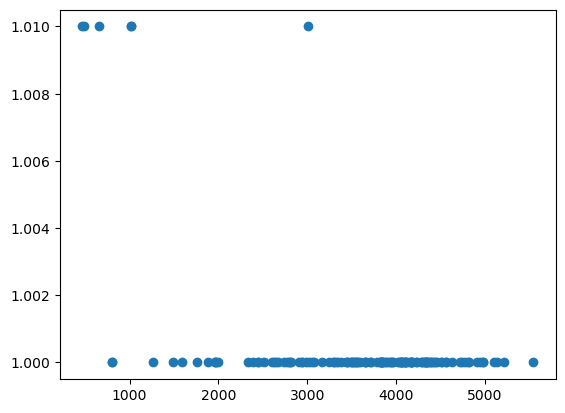

In [41]:
plt.scatter(x = mCDUcov_sum['ess_bulk'], y = mCDUcov_sum['r_hat'])

In [37]:
#Non-centered priors
with pm.Model() as mCDUcov_nc:
    C = pm.MutableData('C',bang['use.contraception'].values)
    D = pm.MutableData('D',bang['district'].values -1)
    U = pm.MutableData('U',bang['urban'])
    #priors 
    sd_dist = pm.Exponential.dist(1,size=2)
    chol,corr, sigmas   = pm.LKJCholeskyCov('Rho', eta = 4, n=2,sd_dist=sd_dist)
    abar  = pm.Normal('abar',0,1)
    bbar = pm.Normal('bbar',0,1)
    
    z    = pm.Normal('z',0,1,shape=(61,2)) #vals_raw in pymc docs
    v    = pm.Deterministic('v', pt.dot(chol,z.T).T) #vals in pymc docs
    
    # Define effects using other parameters
    a = pm.Deterministic('a', abar + v[:,0])
    b = pm.Deterministic('b', bbar + v[:,1])


    logit_p = a[D] +b[D]*U
    Cobs = pm.Bernoulli('Cobs',logit_p = logit_p,observed = C)
    
    mCDUcov_nc_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rho, abar, bbar, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [48]:
mCDUcov_nc_sum = az.summary(mCDUcov_nc_trace,var_names=['~z','~v'])
mCDUcov_nc_sum

G:\Statistical_Rethinking\rethinking\Lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
abar,-0.704,0.099,-0.889,-0.515,0.002,0.001,2775.0,2455.0,1.0
bbar,0.675,0.168,0.349,0.980,0.003,0.002,3492.0,2835.0,1.0
Rho[0],0.555,0.096,0.383,0.733,0.002,0.002,1928.0,2888.0,1.0
Rho[1],-0.418,0.198,-0.798,-0.064,0.004,0.003,2172.0,2693.0,1.0
Rho[2],0.599,0.161,0.287,0.901,0.004,0.003,1744.0,2387.0,1.0
...,...,...,...,...,...,...,...,...,...
b[56],0.785,0.636,-0.403,2.009,0.007,0.007,7606.0,2983.0,1.0
b[57],-0.166,0.553,-1.187,0.864,0.007,0.008,5504.0,3170.0,1.0
b[58],1.015,0.748,-0.306,2.517,0.010,0.010,5693.0,3011.0,1.0
b[59],0.686,0.552,-0.399,1.706,0.006,0.006,7299.0,3071.0,1.0


array([<AxesSubplot: title={'center': 'Rho\n0'}>,
       <AxesSubplot: title={'center': 'Rho\n1'}>,
       <AxesSubplot: title={'center': 'Rho\n2'}>], dtype=object)

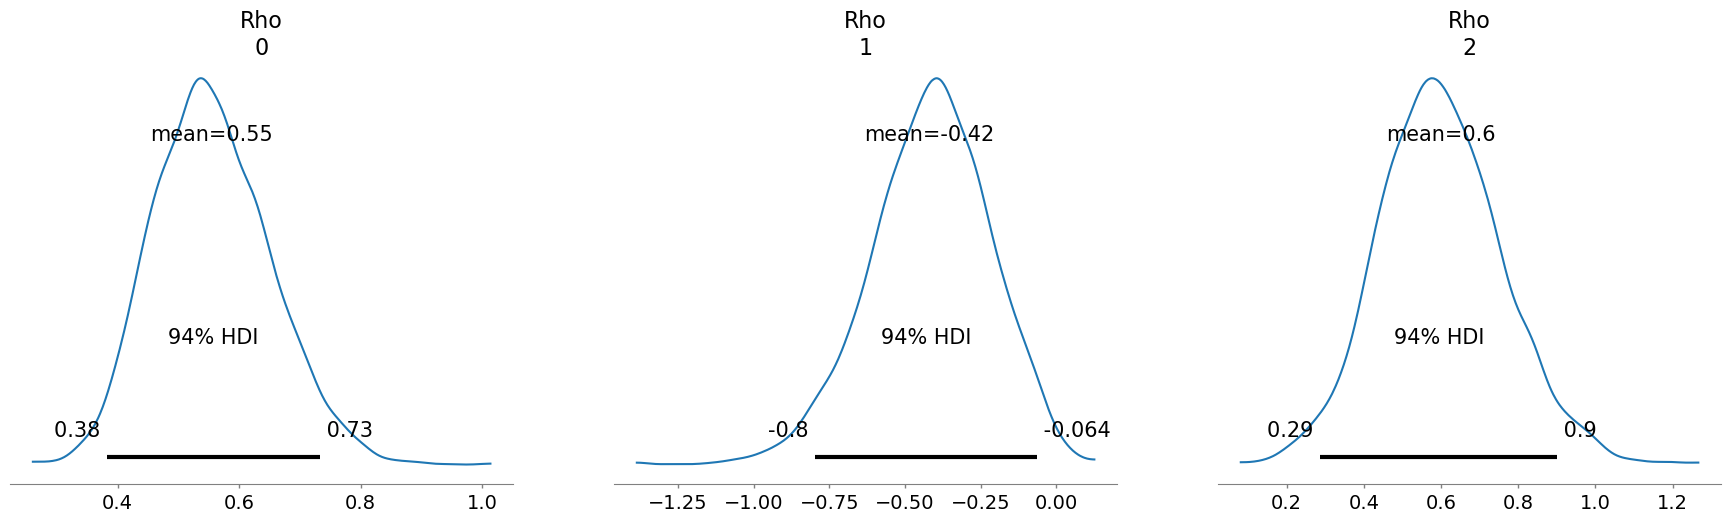

In [47]:
az.plot_posterior(mCDUcov_nc_trace,var_names=['Rho'])

In [58]:
mCDUcov_nc_sum[mCDUcov_nc_sum.index.str.startswith('b')]['mean']

bbar     0.675
b[0]     1.024
b[1]     0.646
b[2]     0.958
b[3]     1.627
         ...  
b[56]    0.785
b[57]   -0.166
b[58]    1.015
b[59]    0.686
b[60]    0.645
Name: mean, Length: 62, dtype: float64

Text(0, 0.5, 'b')

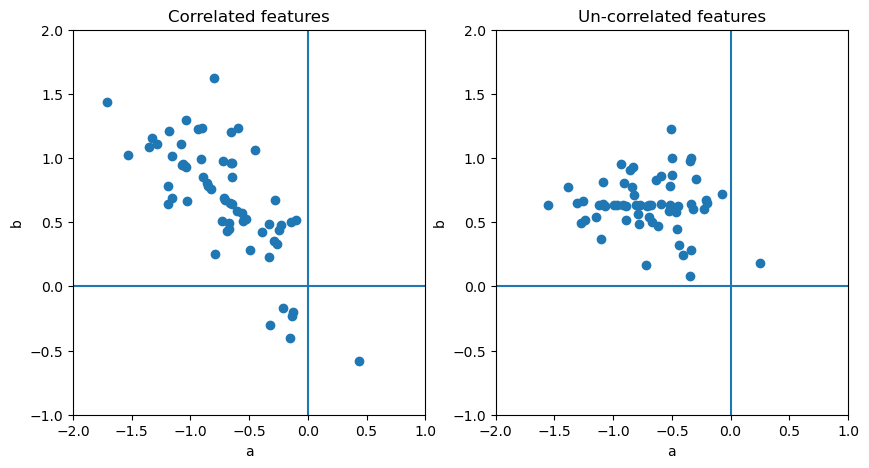

In [96]:

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

ax1.scatter(y=mCDUcov_nc_sum[mCDUcov_nc_sum.index.str.startswith('b')]['mean'],
           x= mCDUcov_nc_sum[mCDUcov_nc_sum.index.str.startswith('a')]['mean'])
ax1.axvline(0)
ax1.axhline(0)
ax1.set_ylim(-1,2)
ax1.set_xlim(-2,1)
ax1.set_title('Correlated features')
ax1.set_xlabel('a')
ax1.set_ylabel('b')

bangunc_sum = az.summary(bangcentred_trace)
ax2.scatter(y=bangunc_sum[bangunc_sum.index.str.startswith('b')]['mean'],
           x= bangunc_sum[bangunc_sum.index.str.startswith('a')]['mean'])
ax2.axvline(0)
ax2.axhline(0)
ax2.set_ylim(-1,2)
ax2.set_xlim(-2,1)

ax2.set_title('Un-correlated features')
ax2.set_xlabel('a')
ax2.set_ylabel('b')

This gave us the ability to estimate the effect of U. 

To get the direct effect of U we would have to stratify by Kids. How would you stratify by kids? You don't have half a kid, each kid may have a different effect. 

Also can try kids themselves (women have stopping rules)

Age has similar issues. 

Should also figure out Synthetic data & testing. This is complex. Non-linear effects. 

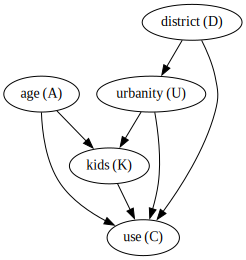

In [78]:
b_graph

Priors that learn correlation structure:

1) Partial pooling across features

2) Learn correlations (This can be very interesting!) 

Varying effects can be correlated even if the prior doesn't learn the correlations